# Human Diffusion

### A Q-Learning Process About The Human Migration From Africa

We start by importing the proper modules (equivalent to libraries in R).

These are

- NumPy
- MatPlotLib
- PIL, (Pillow) an image handler
- tqdm, (pronounced ta-qa-dum) from Arabic (taqadum, تقدّم) meaning *progress*, is a simple progress bar to be able to estimate the time for each task



In [1]:
#pip install -r requirements.txt

In [2]:
from earth import Earth

## Generating the Map
We initialise the picture that we want to use, and convert it into pixel values, so we can have a pure black and white image of the earth to use.

In [3]:
stage = Earth()

The following forloop checks each individual pixel and the converts it to black or white. The threshold was found through running the loop many times and picking a number that looked good enough.

In [4]:
stage.black_and_white('earth.jpg', 'newPixels.csv', 'pure-bw-earth.jpg')

100%|████████████████████████████████| 450632/450632 [00:00<00:00, 3608945.19it/s]


We then generate the new picture and save it before we convert it into an array.

In [5]:
stage.generate_image('pure-bw-earth.jpg')

100%|█████████████████████████████████████████| 619/619 [00:00<00:00, 1212.65it/s]


We are now ready to create the map we will need.

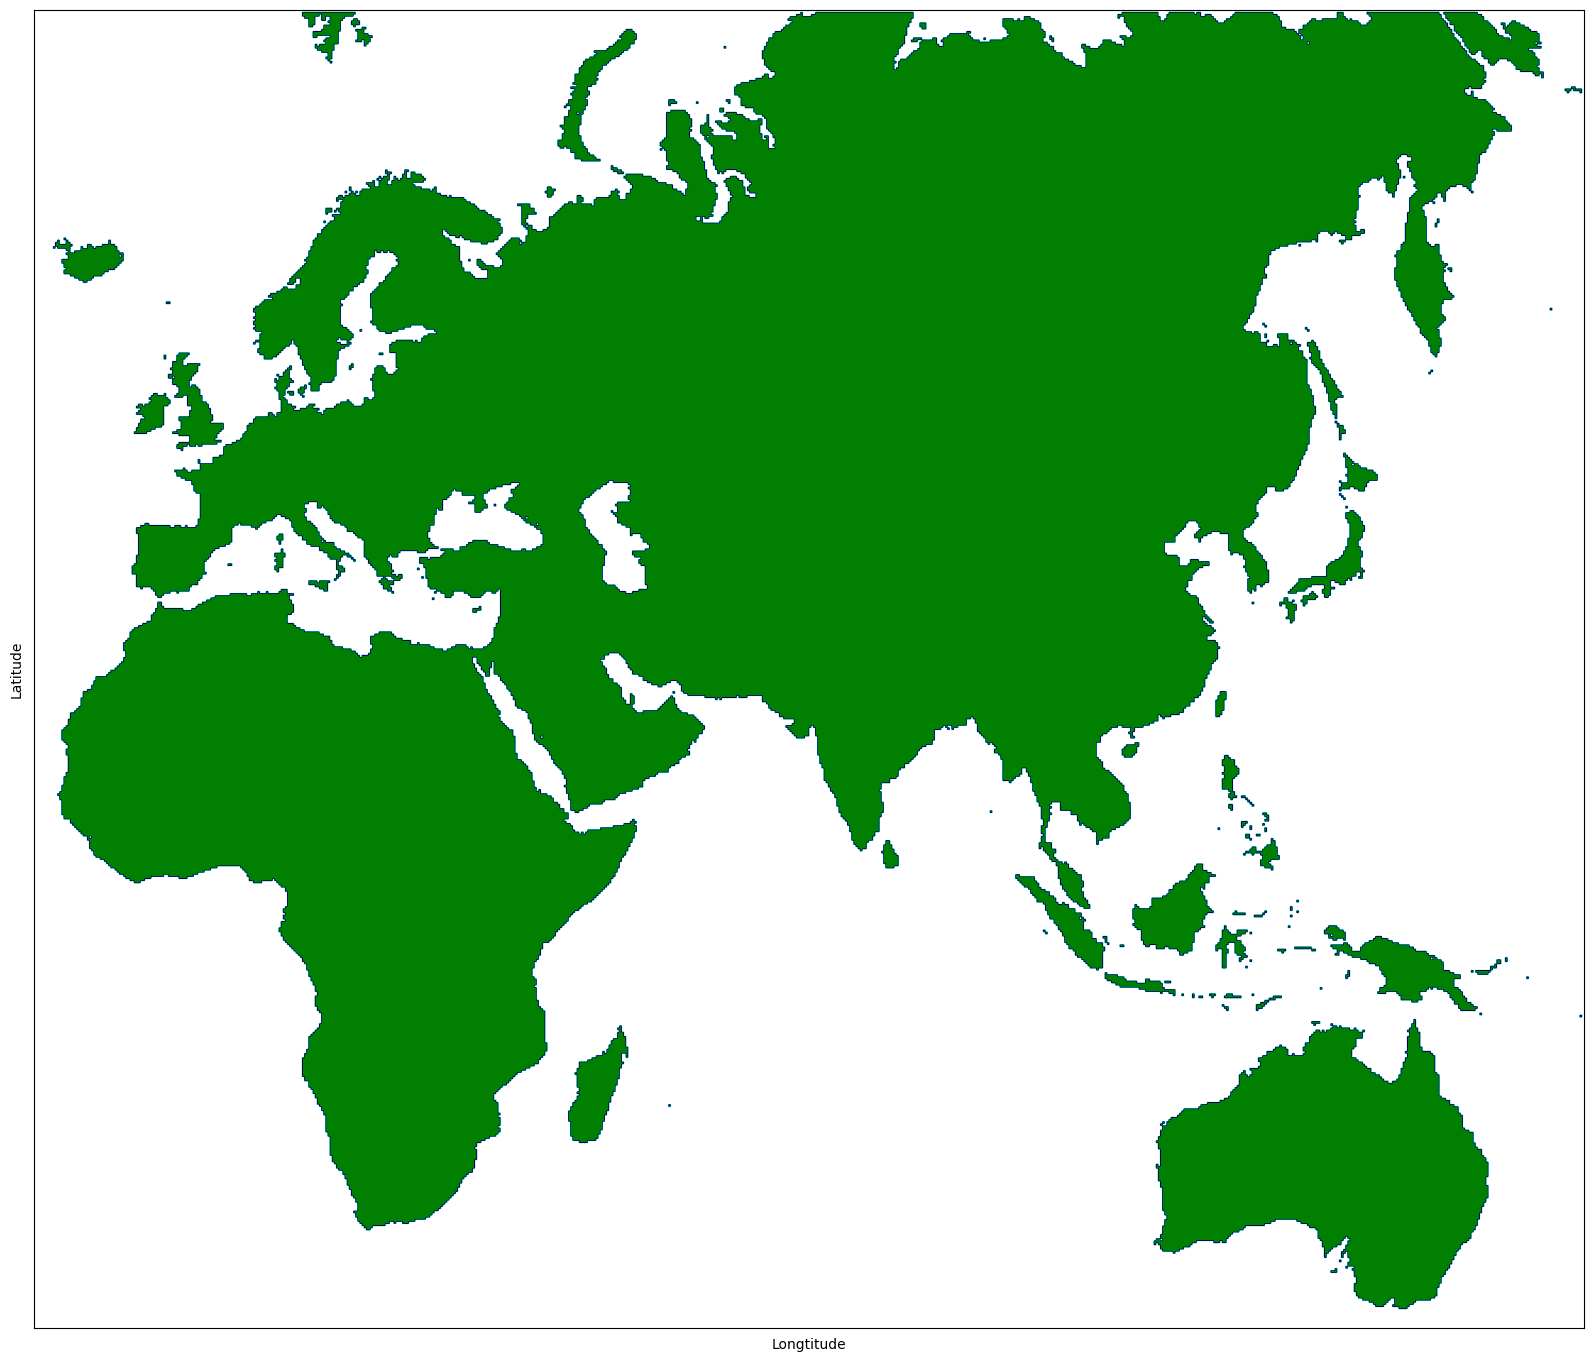

In [6]:
stage.plot('map.jpg')

Now that we have our map ready, we can move on to the implementation of the algorithm.

## Application of the Q-Learning Algorithm in the Simulation of the Single Wave Dispersal Model

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

np.random.seed(1)

In [8]:
actions = ['west', 'east', 'north', 'south']
#coded to 0, 1, 2, 3

Then we can generate the Q-map, which gives the rewards.

In [9]:
q_values = np.random.uniform(-1, 1, size=(stage.height,stage.width, len(actions)))

In [10]:
def starting_area(column, row):
    col = np.random.randint(column[0], column[1])
    row = np.random.randint(row[0], row[1])
    return col, row
    
    
def next_action(current_height, current_width, epsilon):
    if np.random.random() < epsilon:
        move = np.argmax(q_values[current_height, current_width])
    else:
        move = np.random.randint(4)
    return move
    
    
def next_location(height, width, action):
    new_width = width
    new_height = height
    
    if actions[action] == 'west' and width > -1:
        new_width = width - 1
            
    if actions[action] == 'east' and width < stage.width - 1:
        new_width = width + 1
            
    if actions[action] == 'north' and height > 1:
        new_height = height -1
    
    if actions[action] == 'south' and height < stage.height:
        new_height = height +1
        
   
    return new_height, new_width
            

In [ ]:
reward_map = np.zeros(shape=(stage.height,stage.width))
reward_map[np.where(stage.map > 0)] = -10
reward_map[:10, :] = -1500
reward_map[610:, :] = -1500
reward_map[:, 720:] = -1500
reward_map[:, :10] = -1500

#Arabian bridge
reward_map[350:388, 250:282] = 0
reward_map[300:340, 290:315] = 0

# Indonesian bridge
reward_map[417:433, 485:495] = 0
reward_map[450:455, 495:505] = 0
reward_map[460:465, 525:595] = 0

#Australia
reward_map[510:540, 580:610] = 20

real_map = np.ones(shape=(stage.height,stage.width))*10
real_map[np.where(stage.map > 0)] = -10
# real_map[:1, :] = -15

timeline = np.arange(0, 5000)
episodes = np.arange(0, 200000)

reward_per_episode = np.zeros(len(episodes))
lifetime = np.zeros(len(episodes))
ims = []
for episode in tqdm(episodes): #30k

    epsilon = 0.7
    discount_factor = 0.3
    learning_rate = 1

    rewards = np.zeros(len(timeline))
    
#     if episode >= 185000:
#     #India
#         reward_map[390, 388] = 400
                
#     # New Guinea Papua
#         reward_map[455, 650] = 20

#     # Brunei
#         reward_map[425, 540] = 20


    old_height, old_width = 400, 230
    height, width = starting_area([old_height-5, old_height+5], [old_width-5, old_width+5])

    for year in timeline:
        try:

            action = next_action(height, width, epsilon)
            old_height, old_width = height, width
            height, width = next_location(height, width, action)

            reward = reward_map[height, width]
            rewards[year] = reward

            old_q_value = q_values[old_height, old_width, action]
            temporal_difference = reward + (discount_factor*np.max(q_values[height, width])) - old_q_value

            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_height, old_width, action] = new_q_value                

            if reward_map[old_height, old_width] > 0 and reward_map[old_height, old_width] < 100 :
                reward_map[old_height, old_width] = 0

            real_map[old_height-1:old_height+1, old_width-1:old_width+1] = 5

        except IndexError as e:
            break

        if year == timeline[-1]:
            lifetime[episode] = year

        if reward_map[old_height, old_width] <= -10 and reward_map[height, width] <= -10:
            lifetime[episode] = year
            break            

    reward_per_episode[episode] = np.mean(rewards)

plt.figure(figsize = (10,10))
plt.imshow(real_map, cmap = 'ocean_r')
plt.show()

  7%|██▊                                   | 14513/200000 [03:43<49:36, 62.31it/s]

In [ ]:
avg_reward=np.array([])
avg_life = np.array([])
pp = int(len(episodes)/10)

for i in np.arange(len(episodes)):
    if i%pp == 0 and i > 0:
        avg_reward = np.append(avg_reward, np.mean(reward_per_episode[i-pp:i]))
        avg_life = np.append(avg_life, np.mean(lifetime[i-pp:i]))
        
print(len(avg_life))
plt.figure(figsize=(10,5))
plt.title("Average reward")
plt.xlabel('Episodes')
# plt.yscale('log')
# plt.xscale('log')
plt.plot(avg_reward-min(avg_reward))

plt.show()


plt.figure(figsize=(10,5))
# plt.yscale('log')
plt.title("Average Lifetime of Group")
plt.xlabel('Episodes')
plt.ylabel('Generations')
plt.plot(avg_life)
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(q_values)
plt.show()

In [ ]:
reward_map = np.zeros(shape=(stage.height,stage.width))
reward_map[np.where(stage.map > 0)] = -10
reward_map[:10, :] = -15
reward_map[610:, :] = -15
reward_map[:, 720:] = -15
reward_map[:, :10] = -15
#Arabian bridge
reward_map[350:388, 250:282] = 0
reward_map[300:340, 290:315] = 0

# Indonesian bridge
reward_map[417:433, 485:495] = 0
reward_map[450:455, 495:505] = 0
reward_map[460:465, 525:595] = 0
reward_map[460:505, 525:605] = 0


#Australia
reward_map[510:540, 580:610] = 20

plt.figure(figsize = (20,20))
plt.imshow(reward_map)

In [ ]:
real_map = np.ones(shape=(stage.height,stage.width))*10
real_map[np.where(stage.map > 0)] = -10
# real_map[:1, :] = -15

timeline = np.arange(0, 4000)

epsilon = 0.9
discount_factor = 0.7
learning_rate = 0

rewards = np.zeros(len(timeline))
for _ in np.arange(10):

    #Arabian bridge
    reward_map[350:388, 250:282] = 0
    reward_map[300:340, 290:315] = 0

    #Iran
    reward_map[315, 340] = 5

    #India
    reward_map[388, 392] = 20
    reward_map[330, 440] = 40

    #Siamese bridge
    reward_map[370, 480] = 60
    reward_map[370:425, 475:495] = 0

    #Indonesian bridge
    reward_map[430, 485] = 80
    reward_map[430:500, 500:680] = 0
    reward_map[450, 505] = 90

    # New Guinea Papua
    reward_map[455, 650] = 20

    # Brunei
    reward_map[425, 540] = 20


    #Australia
    reward_map[510:540, 580:610] = 100

    old_height, old_width = 400, 230
    height, width = starting_area([old_height-5, old_height+5], [old_width-5, old_width+5])

    for year in timeline:
        try:

            action = next_action(height, width, epsilon)
            old_height, old_width = height, width
            height, width = next_location(height, width, action)

            reward = reward_map[height, width]
            rewards[year] = reward

            old_q_value = q_values[old_height, old_width, action]
            temporal_difference = reward + (discount_factor*np.max(q_values[height, width])) - old_q_value

            new_q_value = old_q_value + (learning_rate * temporal_difference)
            q_values[old_height, old_width, action] = new_q_value                

            if reward_map[old_height, old_width] > 0 and reward_map[old_height, old_width] < 100 :
                reward_map[old_height, old_width] = -1

            real_map[old_height-1:old_height+1, old_width-1:old_width+1] = 5

        except IndexError as e:
            break

        if year == timeline[-1]:
            lifetime[episode] = year

        if reward_map[old_height, old_width] <= -10 and reward_map[height, width] <= -10:
            lifetime[episode] = year
            break            

plt.figure(figsize = (10,10))
plt.imshow(real_map, cmap = 'ocean_r')
plt.show()